In [1]:
import warnings

from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import numpy as np

from scipy.fft import fft, ifft, fftfreq
from scipy.signal import find_peaks, convolve
from scipy import signal
from scipy.stats import ttest_rel, ttest_ind

from statsmodels.tsa.api import ARIMA

from fooof import FOOOF
from fooof.core.funcs import expo_function
from fooof.sim.gen import gen_aperiodic, gen_periodic

from neurodsp.sim import sim_bursty_oscillation, sim_oscillation, sim_synaptic_kernel
from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig

from timescales.sim import (sim_spikes_synaptic, sim_exp_decay, sim_acf_cos, sim_spikes_prob,
                            sim_branching, sim_damped_cos, sim_poisson, sim_probs_combined)
from timescales.fit import ACF, compute_acf, fit_acf, fit_acf_cos, fit_psd, convert_knee_val
from timescales.plts import plot_connected_scatter
from timescales.decompose import ar_psd, ar_psds_bandstop           

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
LARGE_SIZE = 24

plt.rc('lines', linewidth=2)

plt.rc('font', size=SMALL_SIZE, family='sans-serif')
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=LARGE_SIZE)

plt.rc('ytick.major', size=5)
plt.rc('ytick.minor', size=2.5)
plt.rc('xtick.major', size=5)
plt.rc('xtick.minor', size=2.5)

sns.set_palette('colorblind')
sns.color_palette()

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

### Fig. 1 Show spiking and LFP time series, and demonstrate ACF and spectral tau estimation methods

In [3]:
np.random.seed(0)

n_seconds = 100
fs = 1000
tau = convert_knee_val(10)
times = np.arange(0, n_seconds, 1/fs)

# Simulate spikes
probs, spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1, mu=100, refract=10)

# Exponentially smooth spikes
probs_est = ARIMA(spikes, order=(0, 1, 1)).fit().fittedvalues

# Simulate LFP
lfp = sim_branching(n_seconds, fs, tau, 20)
lfp = normalize_sig(lfp, 0, 1)

# Compute ACF
acf_lfp = ACF()
acf_lfp.compute_acf(lfp, fs, nlags=250)

acf_probs_est = ACF()
acf_probs_est.compute_acf(probs_est, fs, nlags=250)

corrs_lfp = acf_lfp.corrs
corrs_probs_est = acf_probs_est.corrs

corrs_lfp /= corrs_lfp.max()
corrs_probs_est /= corrs_probs_est.max()

# Compute PSD
freqs_spikes, powers_spikes = compute_spectrum(normalize_sig(probs_est, 0, 1), fs, f_range=(0, 100))
freqs_lfp, powers_lfp = compute_spectrum(normalize_sig(lfp, 0, 1), fs, f_range=(0, 100))

inds = np.where(freqs_spikes >= 1)
freqs_spikes = freqs_spikes[inds]
powers_spikes = powers_spikes[inds]

inds = np.where(freqs_lfp >= 1)
freqs_lfp = freqs_lfp[inds]
powers_lfp = powers_lfp[inds]

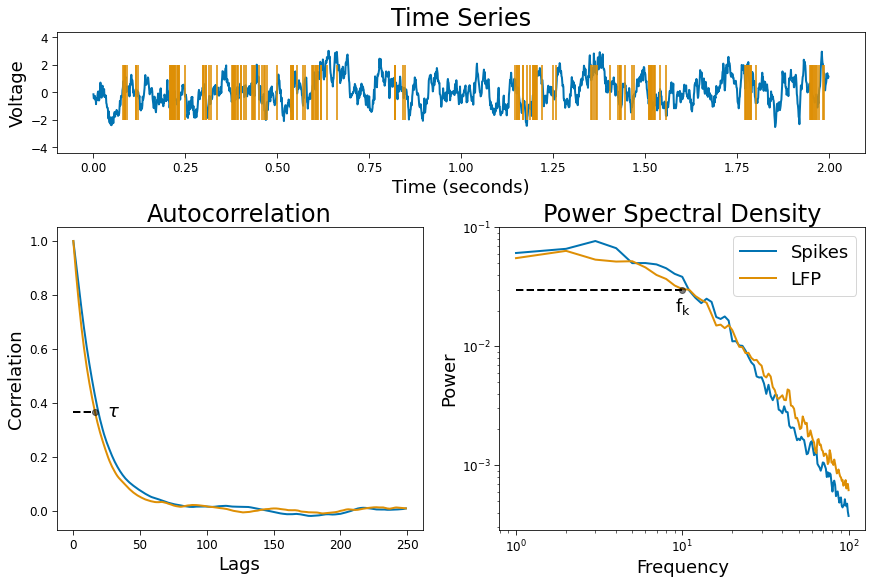

In [4]:
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
gs = GridSpec(7, 2, figure=fig)

ax0 = fig.add_subplot(gs[0:2, :])
ax1 = fig.add_subplot(gs[2:7, 0])
ax2 = fig.add_subplot(gs[2:7, 1])

# Plot LFP
_n_seconds = 2
_lfp = lfp[:int(_n_seconds * fs)]
ax0.plot(times[np.where(times < _n_seconds)[0]], _lfp, zorder=0, label='Spikes')

# Plot Spikes
_times = times[np.where(spikes)[0]]
_times = _times[np.where(_times <= _n_seconds)[0] ]
ax0.eventplot(_times, color='C1', alpha=.8, lineoffsets=0, linelengths=4, zorder=1,)

# Plot ACF
ax1.plot(corrs_probs_est, zorder=1)
ax1.plot(corrs_lfp, zorder=1)

# Plot PSD
ax2.loglog(freqs_spikes, powers_spikes, label='Spikes')
ax2.loglog(freqs_lfp, powers_lfp, label='LFP')
ax2.legend()

# Plot truth
ax1.scatter(convert_knee_val(10) * fs, 1/np.exp(1), zorder=2, color='k', alpha=.5)
ax1.axhline(y=1/np.exp(1), xmin=0.045, xmax=.1, ls='--', color='k')
ax1.text(25, .35, r'$\tau$', size=MEDIUM_SIZE)

_power = (powers_lfp[10] + powers_spikes[10])/2
ax2.scatter(10, _power, zorder=3, color='k', alpha=.5)
ax2.axhline(y=_power, xmin=.045, xmax=.5, ls='--', color='k')
ax2.text(9, _power-.01, r'$\mathregular{f_k}$', size=MEDIUM_SIZE)

# Titles and 
ax0.set_title('Time Series')
ax1.set_title('Autocorrelation')
ax2.set_title('Power Spectral Density')

ax0.set_ylabel('Voltage')
ax0.set_xlabel('Time (seconds)')
ax1.set_xlabel('Lags')
ax1.set_ylabel('Correlation')

ax2.set_xlabel('Frequency')
ax2.set_ylabel('Power');

plt.savefig('fig1_quantify.png', dpi=300, facecolor='w')

### Fig. 2 Show different timescales — short, long, oscillation-present, time-varying / nonstationary—to illustrate how tau estiumates can be biased when assumptions are broken

Show how ACF and spectral perform under each

In [5]:
np.random.seed(3)

fs = 1000
xs = np.arange(1, 10000)
freqs = np.linspace(1, 500, 10000)
tau = convert_knee_val(10)

pe = gen_periodic(freqs, [10, .5, 2])
ap = gen_aperiodic(freqs, [0, 10, 2])
powers = 10**(ap + pe)
powers /= powers[0]

# Oscillations
fooof_init = {'max_n_peaks': 1}
fm_osc, kf_osc, tau_osc = fit_psd(
    freqs, powers, f_range=(0, 10000), knee_bounds=(0, 100), fooof_init=fooof_init)

acf_ap_osc = ifft(10**fm_osc._ap_fit).real
acf_ap_osc = acf_ap_osc[:len(acf_ap_osc)//2][:200]

acf_osc = ifft(10**(fm_osc.power_spectrum)).real
acf_osc = acf_osc[:len(acf_osc)//2][:200]
acf_pe_osc = acf_osc - acf_ap_osc

scale = 1/(acf_ap_osc[0] + acf_pe_osc[0])
acf_pe_osc *= scale
acf_ap_osc *= scale

lags_osc = np.arange(1, 2*len(acf_ap_osc)+1, 2)
inds_osc = np.where(lags_osc <= 300)
lags_osc = lags_osc[inds_osc]

acf_pe_osc = acf_pe_osc[inds_osc]
acf_ap_osc = acf_ap_osc[inds_osc]

fooof_init = {'max_n_peaks': 1}
fm_osc, kf_osc, tau_osc = fit_psd(
    freqs, powers, f_range=(0, 100), knee_bounds=(0, 100), fooof_init=fooof_init)
ap_fit_osc = (10**(fm_osc._ap_fit))
knee_ind = np.argmin(np.abs(freqs-kf_osc))

# Finite
sig_finite = normalize_sig(sim_branching(1, fs, tau, 20), 0, 1)

freqs_finite, powers_finite = compute_spectrum(sig_finite, fs)
corrs_finite = ifft(powers_finite).real
lags_finite = np.arange(1, 2*len(corrs_finite)+1, 2)

inds_finite = np.where(lags_finite <= 300)
lags_finite = lags_finite[inds_finite]
corrs_finite = corrs_finite[inds_finite]

corrs_finite /= corrs_finite.max()
corrs_finite *= acf_ap_osc[0]

inds_finite = np.where((freqs_finite >= 1) & (freqs_finite <= 100))
powers_finite = powers_finite[inds_finite]
powers_finite /= powers_finite[:15].mean()
freqs_finite = freqs_finite[inds_finite]

freqs_finite_burg, powers_finite_burg = ar_psd(sig_finite, fs, 5)
corrs_finite_burg = ifft(powers_finite_burg).real
corrs_finite_burg = corrs_finite_burg[:len(corrs_finite_burg)//2]
lags_finite_burg = np.arange(1, 2*len(corrs_finite_burg)+1, 2)

inds_burg = np.where(lags_finite_burg <= 300)
lags_finite_burg = lags_finite_burg[inds_burg]
corrs_finite_burg = corrs_finite_burg[inds_burg]

corrs_finite_burg /= corrs_finite_burg.max()
corrs_finite_burg *= acf_ap_osc[0]

inds = np.where((freqs_finite_burg >= .5) & (freqs_finite_burg <= 100))[0]
freqs_finite_burg = freqs_finite_burg[inds]
powers_finite_burg = powers_finite_burg[inds]
powers_finite_burg /= powers_finite_burg[0]

# Dynamic
knees = np.linspace(5, 15, 100)

freqs_dynamic = np.linspace(1, 1000, 10000)
powers_dynamic = np.array([(1/(k**2 + freqs_dynamic**2)) for k in knees])

corrs_dynamic = np.zeros((len(powers_dynamic), len(powers_dynamic[0])//2))
lags_dynamic = np.arange(1, len(powers_dynamic[0])+1, 2)

for ind, power in enumerate(powers_dynamic):
    
    acf = ifft(power).real[:len(power)//2]
    acf -= acf.min()
    acf /= acf.max()
    acf *= acf_ap_osc[0]
    
    corrs_dynamic[ind] = acf

powers_mid = (1/(10**2 + freqs_dynamic**2))
powers_mid /= powers_mid[0]

lags_mid = np.arange(1, 2*len(acf_ap_osc)+1, 2)
inds_mid = np.where(lags_mid <= 300)
lags_mid = lags_mid[inds_mid]

corrs_mid = ifft(powers_mid).real[:len(powers_mid)//2]
corrs_mid -= corrs_mid.min()
corrs_mid /= corrs_mid.max()
corrs_mid *= acf_ap_osc[0]
corrs_mid = corrs_mid[inds_mid]

inds = np.where(lags_dynamic <= 300)[0]
lags_dynamic = lags_dynamic[inds]
corrs_dynamic = corrs_dynamic[:, inds]

inds = np.where(freqs_dynamic <= 100)[0]
freqs_dynamic = freqs_dynamic[inds]
powers_dynamic = powers_dynamic[:, inds]
powers_mid = powers_mid[inds]

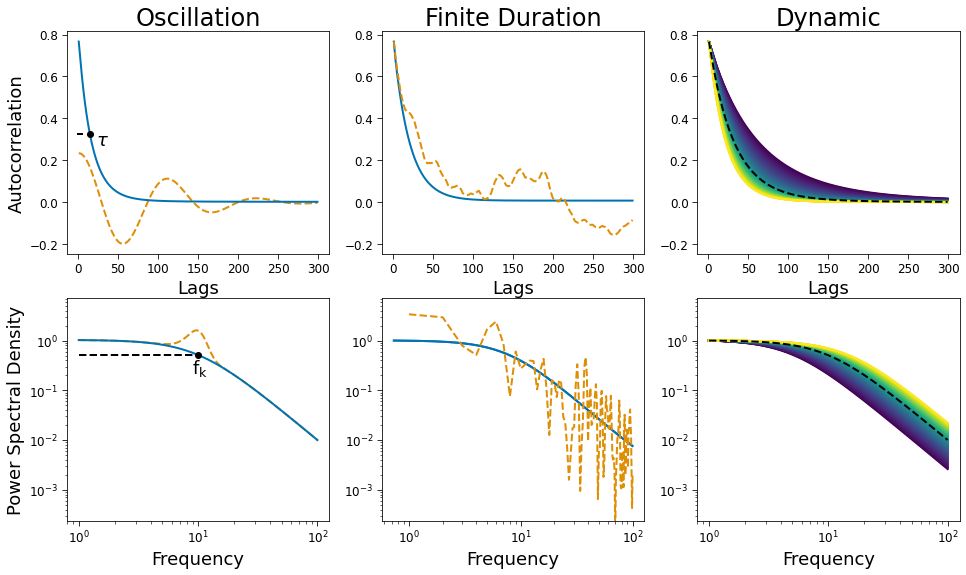

In [6]:
fig, axes = plt.subplots(figsize=(16, 9), nrows=2, ncols=3)

# Oscillations - ACF
axes[0][0].plot(lags_osc, acf_pe_osc, ls='--', color='C1', label='Oscillation')
axes[0][0].plot(lags_osc, acf_ap_osc, color='C0', label='Aperiodic')

ind = np.argmin(np.abs(lags_osc-int(convert_knee_val(10) * fs)))
axes[0][0].scatter(lags_osc[ind], acf_ap_osc[ind], color='k', zorder=4)
axes[0][0].axhline(acf_ap_osc[ind], .04, .06, ls='--', color='k')
axes[0][0].text(lags_osc[ind]+7, acf_ap_osc[ind]-.05, r'$\tau$', size=18)

# Oscillations - PSD
axes[1][0].loglog(fm_osc.freqs, 10**(fm_osc._ap_fit+fm_osc._peak_fit), color='C1', ls='--', label='Oscillation')
axes[1][0].loglog(fm_osc.freqs, 10**fm_osc._ap_fit, color='C0', label='Aperiodic')

axes[1][0].scatter(freqs[knee_ind], ap_fit_osc[knee_ind], color='k', zorder=3)
axes[1][0].axhline(ap_fit_osc[knee_ind]-.009, 0.045, .5, color='k', ls='--')
axes[1][0].text(freqs[knee_ind]-1, ap_fit_osc[knee_ind]-.3, r'$\mathregular{f_k}$', size=18)

# Finite - ACF
axes[0][1].plot(
    lags_finite_burg, corrs_finite_burg, color='C0', label='AR(5)')

axes[0][1].plot(
    lags_finite, corrs_finite, color='C1', ls='--', label='1 Second')

# Finite - PSD
axes[1][1].loglog(freqs_finite_burg, powers_finite_burg, color='C0', label='AR(5)')
axes[1][1].loglog(freqs_finite_burg, powers_finite_burg)
axes[1][1].loglog(freqs_finite, powers_finite, color='C1', label='Welch', ls='--')

# Dynamic - ACF
inds = np.where(freqs_dynamic <= 100)

colors = plt.cm.viridis(np.linspace(0, 1, len(knees)))

for _corrs, c in zip(corrs_dynamic, colors):
    axes[0][2].plot(lags_dynamic[:200], _corrs[:200], color=c)
axes[0][2].plot(lags_osc, corrs_mid, color='k', ls='--')  

# Dynamic - PSD
for p, c in zip(powers_dynamic, colors):
    axes[1][2].loglog(freqs_dynamic, p/p[0], color=c)
axes[1][2].plot(freqs_dynamic, powers_mid, color='k', ls='--')   
    
    
# Axes
ylims = [axes[1][0].get_ylim()[0]-.0075, axes[1][0].get_ylim()[1]+5]
axes[1][0].set_ylim(ylims)
axes[1][1].set_ylim(ylims)
axes[1][2].set_ylim(ylims)

axes[0][1].set_ylim(axes[0][0].get_ylim())
axes[0][2].set_ylim(axes[0][0].get_ylim())

# Titles and labels
axes[0][0].set_xlabel('Lags')
axes[0][1].set_xlabel('Lags')
axes[0][2].set_xlabel('Lags')
axes[1][0].set_xlabel('Frequency')
axes[1][1].set_xlabel('Frequency')
axes[1][2].set_xlabel('Frequency')

axes[0][0].set_ylabel('Autocorrelation')
axes[1][0].set_ylabel('Power Spectral Density')

axes[0][0].set_title('Oscillation')
axes[0][1].set_title('Finite Duration')
axes[0][2].set_title('Dynamic')

plt.savefig('fig2_bias.png', dpi=300, facecolor='w')

### Fig. 3 Simulation

In [7]:
np.random.seed(0)

n_seconds = 1
fs = 1000
times = np.arange(0, n_seconds, 1/fs)

ap_freq = 10
pe_freq = 20

ap_sim_kwargs = dict(mu=50, refract=5)
mean_ap = .12
mean_pe = .22
var_ap = .025
var_pe = .025

# Aperiodic
ap_tau = convert_knee_val(ap_freq)
kernel = sim_synaptic_kernel(10 * ap_tau, fs, 0, ap_tau)

poisson = sim_poisson(n_seconds, fs, kernel, mu=50, refract=5)

n_samples = int(n_seconds * fs)
probs_ap = convolve(poisson, kernel)[:n_samples]
probs_ap = (probs_ap - np.min(probs_ap)) / np.ptp(probs_ap)

# Periodic
probs_pe = sim_oscillation(n_seconds, fs, pe_freq)
probs_pe -= probs_pe.min()
probs_pe /= probs_pe.max()

# Normalize
probs_ap = normalize_sig(probs_ap, mean=mean_ap, variance=var_ap)
probs_pe = normalize_sig(probs_pe, mean=mean_pe, variance=var_pe)
probs = probs_ap + probs_pe

spikes_ap = probs_ap > np.random.rand(len(probs_ap))
spikes = probs > np.random.rand(len(probs))

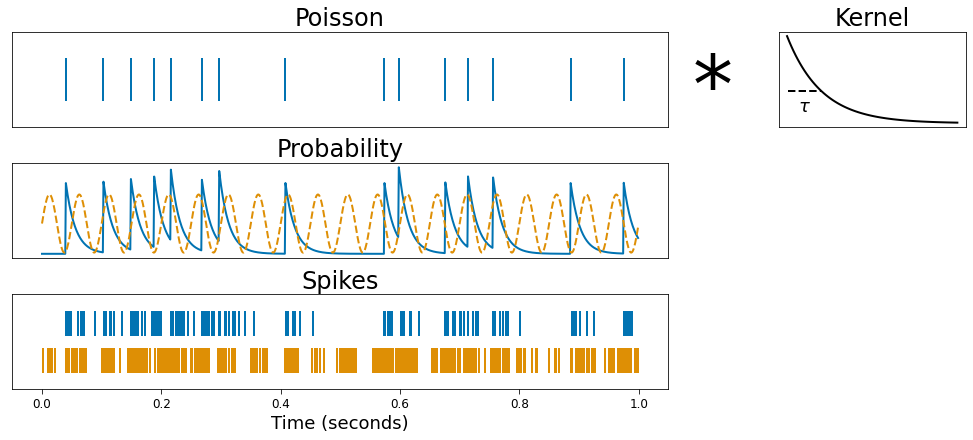

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(16, 6))
gs = fig.add_gridspec(3, 12)

ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:8])
ax2 = fig.add_subplot(gs[0, 8:10])
ax3 = fig.add_subplot(gs[1, :7], sharex=ax0)
ax4 = fig.add_subplot(gs[2, :7], sharex=ax0)

ax0.eventplot(times[np.where(poisson)[0]])
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax0.set_title('Poisson')

ax1.text(.2, 0.15, '*', fontdict={'fontsize': 80})
ax1.axis('off')

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.plot(kernel[:80], color='k')
ax2.axhline(y=np.max(kernel)/np.exp(1), xmin=0.05, xmax=.225, ls='--', color='k')
ax2.text(5, .008, r'$\tau$', size=MEDIUM_SIZE)
ax2.set_title('Kernel')

ax3.plot(times, probs_ap)
ax3.plot(times, probs_pe, ls='--')
ax3.set_title('Probability')
ax3.set_yticks([])
ax3.get_xaxis().set_visible(False)

ax4.eventplot(times[np.where(spikes_ap)[0]], lineoffsets=2.5, color='C0')
ax4.eventplot(times[np.where(spikes)[0]], color='C1')
ax4.set_title('Spikes')
ax4.set_yticks([])
ax4.set_xlabel('Time (seconds)');

plt.savefig('fig3_simulation_a.png', dpi=300, facecolor='white')

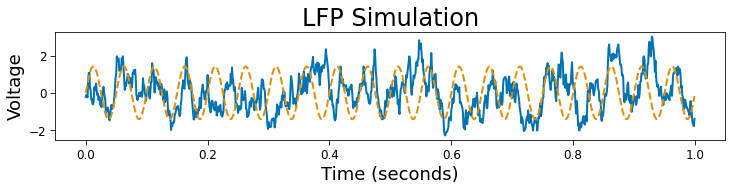

In [9]:
np.random.seed(0)

n_seconds = 1
fs = 1000
tau = convert_knee_val(10)
times = np.arange(0, n_seconds, 1/fs)

sig_branching = sim_branching(n_seconds, fs, tau, 10)
sig_branching = normalize_sig(sig_branching, 0, 1)
sig_osc = sim_oscillation(n_seconds, fs, 20)

plt.figure(figsize=(12, 2))

plt.plot(times, sig_branching)
plt.plot(times, sig_osc, ls='--')

plt.title('LFP Simulation')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')

plt.savefig('fig3_simulation_b.png', dpi=300, facecolor='white', bbox_inches="tight")

### Fig 4. Exponential Smoothing
This demonstrates how to estimate the continuous probability distribution from which spikes are sampled from. This alleviates the issues from using binary spike counts / binned spikes.

In [10]:
np.random.seed(0)

n_seconds = 1
fs = 1000
times = np.arange(0, n_seconds, 1/fs)

ap_freq = 10
pe_freq = 20

ap_sim_kwargs = dict(mu=50, refract=5)
mean_ap = .12
mean_pe = .22
var_ap = .025
var_pe = .025


# Aperiodic
ap_tau = convert_knee_val(ap_freq)
kernel = sim_synaptic_kernel(10 * ap_tau, fs, 0, ap_tau)

poisson = sim_poisson(n_seconds, fs, kernel, mu=50, refract=5)

n_samples = int(n_seconds * fs)
probs_ap = convolve(poisson, kernel)[:n_samples]
probs_ap = (probs_ap - np.min(probs_ap)) / np.ptp(probs_ap)

probs_ap -= probs_ap.min()
probs_ap /= probs_ap.max()

spikes = probs_ap > np.random.rand(len(probs_ap))

es = ARIMA(spikes, order=(0, 1, 1)).fit().fittedvalues

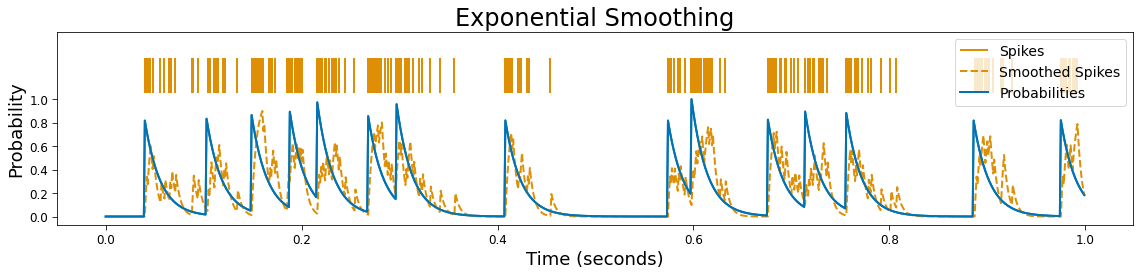

In [11]:
fig, axes = plt.subplots(figsize=(16, 4))

axes.eventplot(times[np.where(spikes)[0]], lineoffsets=1.2, linelengths=.3, color='C1', label='Spikes')
axes.plot(times, probs_ap)

axes.legend(fontsize=14)
axes.set_yticks([0, .2, .4, .6, .8, 1.])


axes.plot(times, es, color='C1', ls='--', label='Smoothed Spikes')
axes.plot(times, probs_ap, color='C0', label='Probabilities')
axes.legend(fontsize=14, loc='upper right')


axes.set_title('Spike Simulation')
axes.set_title('Exponential Smoothing')


axes.set_xlabel('Time (seconds)')
axes.set_ylabel('Probability')

plt.tight_layout()

plt.savefig('fig4_exponential_smoothing.png', dpi=300, facecolor='white')

### Fig. 5 Bias Solutions 

#### LFP

Below are solutions to finite duration and oscillatory biases in LFP simulations.

In [12]:
n_seconds = 100
fs = 1000
tau = convert_knee_val(10)
f_range = (0, 100)
knee_bounds = (1, 100)

niters = 100

knees_lfp_osc_peak = np.zeros(niters)
knees_lfp_osc_no_peak = np.zeros(niters)

p_lfp_osc = np.zeros(501)

for n in tqdm(range(niters)):
    
    np.random.seed(n)
    
    sig, _ = sim_spikes_synaptic(n_seconds, fs, tau)
    osc = sim_oscillation(n_seconds, fs, 20)
    osc -= osc.min()
    osc /= osc.max()
    
    sig = (sig * .5) + (osc * .1)
    
    f_lfp_osc, _p_lfp_osc = compute_spectrum(sig, fs)
    
    _, knee_peak, _ = fit_psd(f_lfp_osc, _p_lfp_osc, f_range, knee_bounds=knee_bounds,
                              fooof_init={'max_n_peaks': 1})
    
    _, knee_no_peak, _ = fit_psd(f_lfp_osc, _p_lfp_osc, f_range, knee_bounds=knee_bounds,
                                 fooof_init={'max_n_peaks': 0})
    
    
    knees_lfp_osc_peak[n] = knee_peak
    knees_lfp_osc_no_peak[n] = knee_no_peak
    
    p_lfp_osc += _p_lfp_osc
    
p_lfp_osc /= niters

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
n_seconds = 2
fs = 1000
knee_freq = 10
tau = convert_knee_val(knee_freq)

f_range = (0, 100)
knee_bounds = (0, 100)

ar_order = 1

knees_lfp_finite_welch = np.zeros(niters)
knees_lfp_finite_ar = np.zeros(niters)

for n in tqdm(range(niters)):
    
    np.random.seed(n)
    
    # Simulate
    sig = sim_branching(n_seconds, fs, tau, 200)
    sig = normalize_sig(sig, 0, 1)
    
    # Welch's PSD
    f_lfp_finite_welch, p_lfp_finite_welch = compute_spectrum(sig, fs)
    
    _, knee_welch, _ = fit_psd(f_lfp_finite_welch, p_lfp_finite_welch,
                               f_range, knee_bounds=knee_bounds, fooof_init={'max_n_peaks': 0})
    
    knees_lfp_finite_welch[n] = knee_welch
    
    # AR(p) PSD
    f_lfp_finite_ar, p_lfp_finite_ar = ar_psd(sig, fs, ar_order)
    
    _, knee_ar, _ = fit_psd(f_lfp_finite_ar, p_lfp_finite_ar,
                            f_range, knee_bounds=knee_bounds, fooof_init={'max_n_peaks': 0})
    
    knees_lfp_finite_ar[n] = knee_ar

  0%|          | 0/100 [00:00<?, ?it/s]

#### Spikes

Below is a solution to the finite duration and oscillatory biases for spike trains.

In [14]:
def _osc_parallel_fit(seeds):
    """Fit oscillatory simulations for spikes in parallel."""
    
    # Settings
    n_seconds = 2
    fs = 1000
    
    ap_freq = 10
    pe_freq = 20

    ap_sim_kwargs = dict(mu=50, refract=5)

    f_range = (0, 100)

    # Simulate (a)periodic spiking probabilities
    base_seed, inner_seed = seeds
    np.random.seed(base_seed+inner_seed)
    
    probs_ap, probs_pe = sim_probs_combined(
        n_seconds, fs, ap_freq, pe_freq, ap_sim_kwargs,
        mean=(.12, .22), var=(.025, .025)
    )
    
    # Combine probabilities
    probs = probs_ap + probs_pe

    # Sample spikes from probabilities
    spikes_osc = probs > np.random.rand(len(probs))

    # Exponentially smooth
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        es_osc = ARIMA(spikes_osc, order=(0, 1, 1)).fit().fittedvalues

    # Oscillations: Peak
    f, p = compute_spectrum(es_osc, fs)

    fooof_init={'max_n_peaks': 1, 'peak_threshold': 2.5}

    _, knee_osc_peak, _ = fit_psd(f, p, f_range,
                                  fooof_init=fooof_init, knee_bounds=f_range)

    # Oscillations: No Peak
    fooof_init={'max_n_peaks': 0, 'peak_threshold': 2.5}

    _, knee_osc_no_peak, _ = fit_psd(f, p, f_range, 
                                     fooof_init=fooof_init, knee_bounds=f_range)
    
    return knee_osc_no_peak, knee_osc_peak, f, p


def _finite_parallel_fit(seed, return_psds=False):
    """Fit finite simulations in parallel."""
    
    # Settings
    np.random.seed(seed)
    
    ar_order = 5
    n_seconds = 2
    ap_freq = 10
    ap_tau = convert_knee_val(ap_freq)
    fs = 1000
    f_range = (0, 100)
    fooof_init = dict(max_n_peaks=0)
    
    # Simulate probabilities
    kernel = sim_synaptic_kernel(20 * ap_tau, fs, 0, ap_tau)
    
    probs = sim_spikes_prob(n_seconds, fs, kernel=kernel, mu=50, refract=10)
    
    # Sample spikes from probabilities
    spikes = probs > np.random.rand(len(probs))

    # Exponentially smooth
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        es = ARIMA(spikes, order=(0, 1, 1)).fit().fittedvalues
        
    # Finite: AR
    f_ar, p_ar = ar_psd(es, fs, ar_order)
    _, knee_finite_ar, _ = fit_psd(f_ar, p_ar, f_range,
                                   knee_bounds=f_range, fooof_init=fooof_init)
    
    # Finite: Welch
    f_welch, p_welch = compute_spectrum(spikes, fs)
    _, knee_finite_welch, _ = fit_psd(f_welch, p_welch, f_range,
                                      knee_bounds=f_range, fooof_init=fooof_init)
    
    return knee_finite_welch, knee_finite_ar, f_welch, p_welch, f_ar, p_ar

In [15]:
niters = 100

# Set random seeds for osc simulations
outer_seeds = np.arange(0, niters*50, 50)
inner_seeds = np.arange(0, 50)

seeds = np.zeros((len(outer_seeds) * len(inner_seeds), 2), dtype=int)

ind = 0
for o in outer_seeds:
    for i in inner_seeds:
        seeds[ind][0] = o
        seeds[ind][1] = i
        ind += 1

# Run oscillatory simulations in parallel
with Pool(cpu_count()) as pool:
        
    mapping = pool.imap(_osc_parallel_fit, seeds)
    
    results = list(tqdm(mapping, dynamic_ncols=True, total=len(seeds)))
    
# Take the mean of inner-loop oscillatory simulations to limit finite bias
knees_osc_no_peak = np.array([i[0] for i in results]).reshape(niters, -1).mean(axis=1)
knees_osc_peak = np.array([i[1] for i in results]).reshape(niters, -1).mean(axis=1)

# Get PSDs
f_spikes_osc = results[0][2]
p_spikes_osc = np.array([i[3] for i in results])

  0%|          | 0/5000 [00:00<?, ?it/s]

In [16]:
# Run finite simulations in parallel
seeds = np.arange(100)

with Pool(cpu_count()) as pool:
        
    mapping = pool.imap(_finite_parallel_fit, seeds)
    
    results = list(tqdm(mapping, dynamic_ncols=True, total=len(seeds)))

knees_finite_welch = np.array([i[0] for i in results])
knees_finite_ar = np.array([i[1] for i in results])

f_welch = results[0][2]
p_welch = np.array([i[3] for i in results])
f_ar = results[0][4]
p_ar = np.array([i[5] for i in results])

  0%|          | 0/100 [00:00<?, ?it/s]

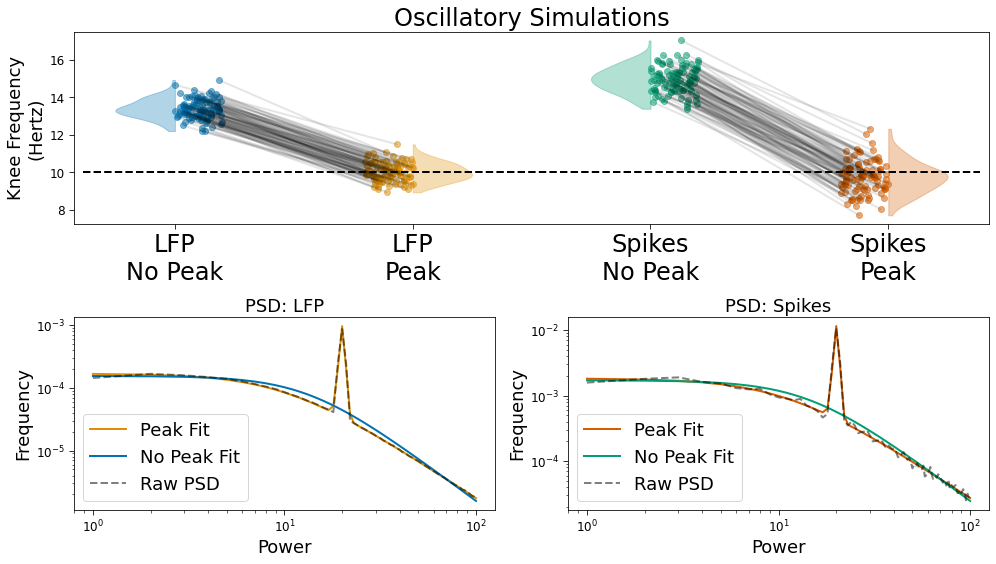

In [18]:
fig = plt.figure(figsize=(14, 8))

gs = GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

title=None
paired=True
alpha_scatter=.5
alpha_line=.1
ylim=None
ylabel=None
xticklabels=None
    
# Regenerate Fits
fooof_init=dict(max_n_peaks=1, peak_threshold=2.5)
fm_peak, _, _ = fit_psd(f_lfp_osc, p_lfp_osc, (0, 100), fooof_init, (0, 100))

fooof_init=dict(max_n_peaks=0, peak_threshold=2.5)
fm_no_peak, _, _ = fit_psd(f_lfp_osc, p_lfp_osc, (0, 100), fooof_init, (0, 100))


fooof_init=dict(max_n_peaks=1, peak_threshold=2.5)
fm_spikes_peak, _, _ = fit_psd(f_spikes_osc, p_spikes_osc[:50].mean(axis=0),
                               (0, 100), fooof_init, (0, 100))

fooof_init=dict(max_n_peaks=0, peak_threshold=2.5)
fm_spikes_no_peak, _, _ = fit_psd(f_spikes_osc, p_spikes_osc[:50].mean(axis=0),
                                  (0, 100), fooof_init, (0, 100))

# Oscillations: LFP
plot_connected_scatter(knees_lfp_osc_no_peak, knees_lfp_osc_peak, ax0, scatter_a_loc=(1, 1.2),
                       scatter_b_loc=(1.8, 2), colors=('C0', 'C1'), violin_locs=(1, 2))

# Oscillations: Spikes
xticklabels = ['LFP\nNo Peak', 'LFP\nPeak', 'Spikes\nNo Peak', 'Spikes\nPeak']
plot_connected_scatter(knees_osc_no_peak, knees_osc_peak, ax0, scatter_a_loc=(3, 3.2),
                       scatter_b_loc=(3.8, 4), colors=('C2', 'C3'), violin_locs=(3, 4),
                       xticks=[1, 2, 3, 4], xticklabels=xticklabels)


ax0.axhline(10, .01, .99, color='k', ls='--', label='Simulated Ground Truth')

# PSDs
ax1.loglog(fm_peak.freqs, 10**fm_peak.fooofed_spectrum_,
           color='C1', label='Peak Fit')

ax1.loglog(fm_no_peak.freqs, 10**fm_no_peak.fooofed_spectrum_,
           color='C0', label='No Peak Fit')

ax1.loglog(fm_peak.freqs, 10**fm_peak.power_spectrum,
           color='k', ls='--', alpha=.5, label='Raw PSD')

ax2.loglog(fm_spikes_peak.freqs, 10**fm_spikes_peak.fooofed_spectrum_,
           color='C3', label='Peak Fit')

ax2.loglog(fm_spikes_no_peak.freqs, 10**fm_spikes_no_peak.fooofed_spectrum_,
           color='C2', label='No Peak Fit')

ax2.loglog(fm_spikes_peak.freqs, 10**fm_spikes_peak.power_spectrum,
           color='k', ls='--', alpha=.5, label='Raw PSD')

ax0.set_title('Oscillatory Simulations')
ax1.set_title('PSD: LFP', size=MEDIUM_SIZE)
ax2.set_title('PSD: Spikes', size=MEDIUM_SIZE)

ax0.set_ylabel('Knee Frequency\n(Hertz)')

ax1.set_ylabel('Frequency')
ax2.set_ylabel('Frequency')

ax1.set_xlabel('Power')
ax2.set_xlabel('Power')

ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('fig5a_oscillations.png', dpi=300, facecolor='white')

In [19]:
print('LFP, Osc: ', ttest_rel(knees_lfp_osc_no_peak, knees_lfp_osc_peak))
print('Spikes, Osc: ', ttest_rel(knees_osc_no_peak, knees_osc_peak))

LFP, Osc:  Ttest_relResult(statistic=150.52789601374022, pvalue=1.0235079277425323e-118)
Spikes, Osc:  Ttest_relResult(statistic=135.33823799843108, pvalue=3.6442050341557525e-114)


In [20]:
print('LFP, Osc No Peak: ', knees_lfp_osc_no_peak.mean(), knees_lfp_osc_no_peak.std())
print('LFP, Osc Peak: ', knees_lfp_osc_peak.mean(),  knees_lfp_osc_peak.std())

print('Spikes, Osc No Peak: ', knees_osc_no_peak.mean(), knees_osc_no_peak.std())
print('Spikes, Osc Peak: ', knees_osc_peak.mean(), knees_osc_peak.std())

LFP, Osc No Peak:  13.402074082841295 0.5201331891646457
LFP, Osc Peak:  10.021440530554706 0.5043531955686509
Spikes, Osc No Peak:  14.954939826962423 0.7016548796928145
Spikes, Osc Peak:  9.732206055371545 0.8510965315659706


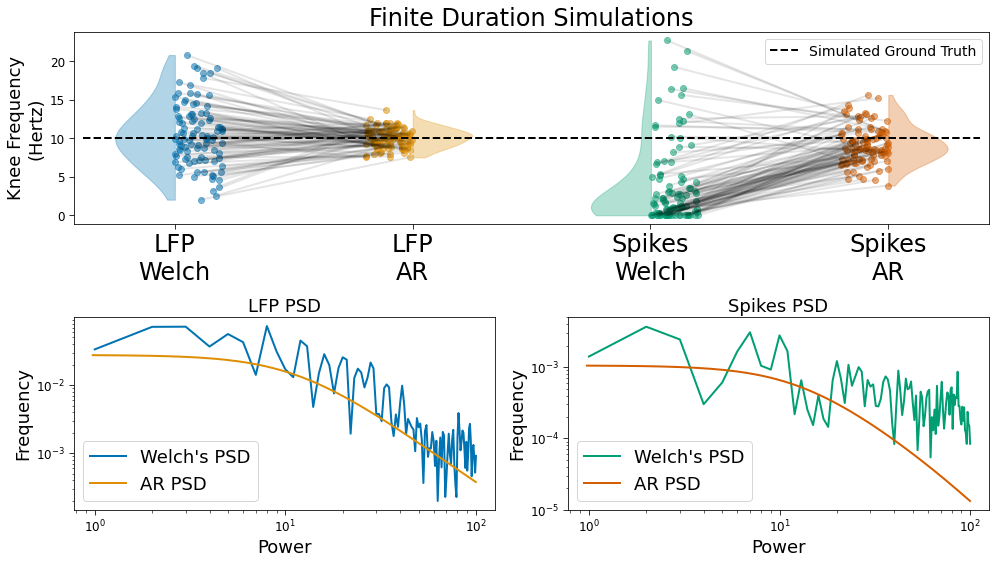

In [21]:
fig = plt.figure(figsize=(14, 8))

gs = GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

# Finite: LFP
plot_connected_scatter(knees_lfp_finite_welch, knees_lfp_finite_ar, ax0, scatter_a_loc=(1, 1.2),
                        scatter_b_loc=(1.8, 2), colors=('C0', 'C1'), violin_locs=(1, 2))

# Finite: Spikes
xticklabels = ['LFP\nWelch', 'LFP\nAR', 'Spikes\nWelch', 'Spikes\nAR']
plot_connected_scatter(knees_finite_welch, knees_finite_ar, ax0, scatter_a_loc=(3, 3.2), 
                       scatter_b_loc=(3.8, 4), colors=('C2', 'C3'), violin_locs=(3, 4),
                       xticks=[1, 2, 3, 4], xticklabels=xticklabels)

ax0.axhline(10, .01, .99, color='k', ls='--', label='Simulated Ground Truth')
ax0.legend(fontsize=14)

# PSDs
inds = np.where((f_lfp_finite_welch <= 100) & (f_lfp_finite_welch >= 1)) 
ax1.loglog(f_lfp_finite_welch[inds], p_lfp_finite_welch[inds],
           color='C0', label='Welch\'s PSD')

inds = np.where((f_lfp_finite_ar <= 100) & (f_lfp_finite_ar >= .8))
ax1.loglog(f_lfp_finite_ar[inds], p_lfp_finite_ar[inds],
           color='C1', label='AR PSD')

inds = np.where((f_welch <= 100) & (f_welch >= 1))
ax2.loglog(f_welch[inds], p_welch[0][inds],
           color='C2', label='Welch\'s PSD')

inds = np.where((f_ar <= 100) & (f_ar >= .8))
ax2.loglog(f_ar[inds], p_ar[0][inds],
           color='C3', label='AR PSD')

ax2.set_ylim(10e-6, 10e-3/2)

ax0.set_title('Finite Duration Simulations')
ax1.set_title('LFP PSD', size=MEDIUM_SIZE)
ax2.set_title('Spikes PSD', size=MEDIUM_SIZE)

ax0.yaxis.set_tick_params()
ax0.set_ylabel('Knee Frequency\n(Hertz)')


ax1.set_ylabel('Frequency')
ax2.set_ylabel('Frequency')

ax1.set_xlabel('Power')
ax2.set_xlabel('Power')

ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('fig5b_finite.png', dpi=300, facecolor='w')

In [22]:
print('LFP, Finite: ', ttest_rel(knees_lfp_finite_welch, knees_lfp_finite_ar))
print('Spikes, Finite: ', ttest_rel(knees_finite_welch, knees_finite_ar))

LFP, Finite:  Ttest_relResult(statistic=1.2732082183432334, pvalue=0.20592572394383632)
Spikes, Finite:  Ttest_relResult(statistic=-11.497276043758362, pvalue=6.151330450161621e-20)


In [23]:
print('LFP, Finite Welch: ', knees_lfp_finite_welch.mean(), knees_lfp_finite_welch.std())
print('LFP, Finite AR: ', knees_lfp_finite_ar.mean(),  knees_lfp_finite_ar.std())

print('Spikes, Finite Welch: ', knees_finite_welch.mean(), knees_finite_welch.std())
print('Spikes, Finite AR: ', knees_finite_ar.mean(), knees_finite_ar.std())

LFP, Finite Welch:  10.547784809618504 4.03848173606287
LFP, Finite AR:  10.06407271757084 1.2207014321039298
Spikes, Finite Welch:  3.8759938330395003 5.2212490935340785
Spikes, Finite AR:  9.145540874426688 2.40665226540442


### Fig. 5 Bias Solutions: Combined

This section provides a solution to both sources of bias in continuous simulations. The idea is to use a sliding bandstop filter to isolate two timescales, one from an oscillation one from an aperiodic process. Bandstopping the oscillation will provide an estimated of the aperiodic timescale, and bandstopping the aperiodic knee frequency provides an estimate for the oscillatory timescale.

In [24]:
def _comb_spike_fit(seed, mode='spikes'):
    """Fit finite and oscillatory solutions for spikes in parallel."""
    
    # Settings
    np.random.seed(seed)
    n_seconds = 2
    fs = 1000
    
    ap_freq = 10
    pe_freq = 20

    ap_sim_kwargs = dict(mu=50, refract=5)

    f_range = (0, 100)
    
    # Init
    #b_ranges = np.array([[8, 12], [18, 22]])
    freqs_lo = np.arange(2, 50)
    freqs_hi = freqs_lo + 3

    b_ranges = np.column_stack((freqs_lo, freqs_hi))
    
    # Simulate (a)periodic spiking probabilities
    if mode == 'spikes':
        ar_order = 6
        
        probs_ap, probs_pe = sim_probs_combined(
            n_seconds, fs, ap_freq, pe_freq, ap_sim_kwargs,
            mean=(.12, .22), var=(.025, .025)
        )
    
        # Combine probabilities
        probs = probs_ap + probs_pe

        # Sample spikes from probabilities
        spikes_osc = probs > np.random.rand(len(probs))

        # Exponentially smooth
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            sig_osc = ARIMA(spikes_osc, order=(0, 1, 1)).fit().fittedvalues
    else:
        ar_order = 5
        # Branching
        tau = convert_knee_val(ap_freq)
        sig = sim_branching(n_seconds, fs, tau, 100)
        sig = normalize_sig(sig, 0, 1)

        # Oscillations
        osc = sim_oscillation(n_seconds, fs, 20)
        sig_osc = (sig/2) + (osc/2)
        
    # Oscillations: Peak
    filter_kwargs = {'n_seconds': .9, 'remove_edges': False}
    freqs, powers, _ = ar_psds_bandstop(sig_osc, fs, b_ranges, ar_order,
                                        filter_kwargs=filter_kwargs)

    _, knees, _ = fit_psd(freqs, powers, f_range, knee_bounds=knee_bounds,
                          fooof_init={'max_n_peaks': 1, 'peak_threshold': 2.5}, n_jobs=1)
        
    knees_lo = knees.min()
    knees_hi = knees.max()
    
    return knees_lo, knees_hi

In [25]:
seeds = np.arange(100)

# Fit spikes
with Pool(cpu_count()) as pool:
    
    mapping = pool.imap(_comb_spike_fit, seeds)
    
    results = list(tqdm(mapping, total=len(seeds)))
    
results = np.array(results)

knees_spikes_lo = results[:, 0]
knees_spikes_hi = results[:, 1]

# Fit LFPs
with Pool(cpu_count()) as pool:
    
    mapping = pool.imap(partial(_comb_spike_fit, mode='lfp'), seeds)
    
    results = list(tqdm(mapping, total=len(seeds)))
    
results = np.array(results)

knees_lfp_lo = results[:, 0]
knees_lfp_hi = results[:, 1]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
# Example PSDs
np.random.seed(0)
    
freqs_lo = np.arange(2, 50)
freqs_hi = freqs_lo + 3
b_ranges = np.array([[8, 12], [18, 22]])

# No oscillations
sig = sim_branching(n_seconds, fs, tau, 100)
sig = normalize_sig(sig, 0, 1)

# Oscillations
osc = sim_oscillation(n_seconds, fs, 20)
sig_osc = (sig/2) + (osc/2)

ar_order = 5
filter_kwargs = {'n_seconds': .9, 'remove_edges': False}
freqs, powers, _ = ar_psds_bandstop(sig_osc, fs, b_ranges, ar_order,
                                    filter_kwargs=filter_kwargs)

fm, knees, _ = fit_psd(freqs, powers, f_range, knee_bounds=knee_bounds,
                      fooof_init={'max_n_peaks': 1, 'peak_threshold': 2.5})

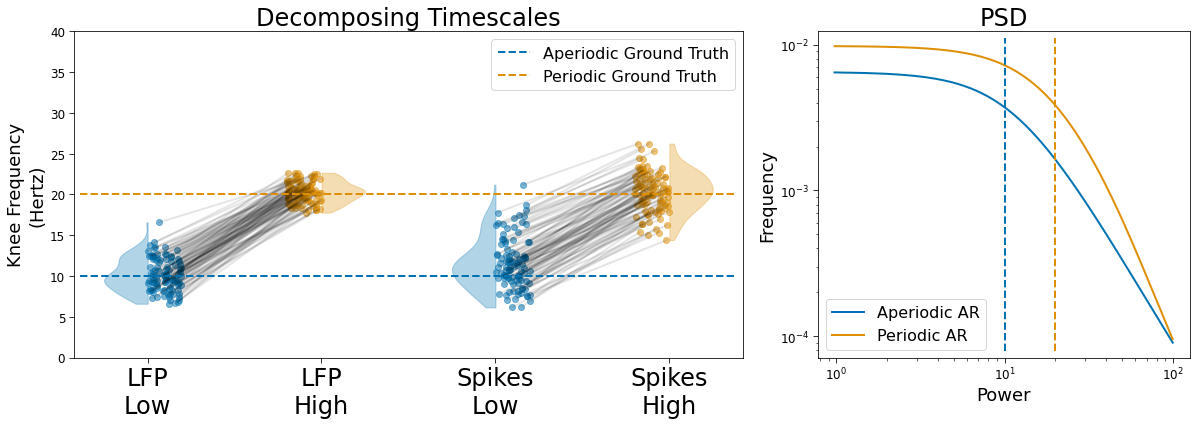

In [27]:
fig = plt.figure(figsize=(20, 6))

gs = GridSpec(1, 8, wspace=1)
ax0 = fig.add_subplot(gs[:5])
ax1 = fig.add_subplot(gs[5:])


# Finite: LFP
plot_connected_scatter(knees_lfp_lo, knees_lfp_hi, ax0, scatter_a_loc=(1, 1.2),
                        scatter_b_loc=(1.8, 2), colors=('C0', 'C1'), violin_locs=(1, 2))

# Finite: Spikes
xticklabels = ['LFP\nLow', 'LFP\nHigh', 'Spikes\nLow', 'Spikes\nHigh']

plot_connected_scatter(knees_spikes_lo, knees_spikes_hi, ax0, scatter_a_loc=(3, 3.2), 
                       scatter_b_loc=(3.8, 4), colors=('C0', 'C1'), violin_locs=(3, 4),
                       xticks=[1, 2, 3, 4], xticklabels=xticklabels)

# Ground truth
ax0.axhline(10, .01, .99, color='C0', ls='--', label='Aperiodic Ground Truth')
ax0.axhline(20, .01, .99, color='C1', ls='--', label='Periodic Ground Truth')

ax0.set_title('Decomposing Timescales')
ax0.legend(fontsize=16)
ax0.set_ylim(0, 40)
ax0.yaxis.set_tick_params()
ax0.set_ylabel('Knee Frequency\n(Hertz)')

# PSD
inds = np.where((freqs >= .8) & (freqs <= 100))

ax1.loglog(freqs[inds], powers[1][inds], label='Aperiodic AR')
ax1.loglog(freqs[inds], powers[0][inds], label='Periodic AR')

ax1.axvline(10, .02, .98, color='C0', ls='--')
ax1.axvline(20, .02, .98, color='C1', ls='--')

ax1.legend(fontsize=16);


ax1.set_ylabel('Frequency')
ax1.set_xlabel('Power');
ax1.set_title('PSD')

plt.savefig('fig5_decompose.png', dpi=300, facecolor='w')

### Fig. 6 Rat Results

In [28]:
import os.path as op

import numpy as np
from scipy.io import loadmat

from timescales.mp import compute_taus
from timescales.fit import convert_knee_val
from timescales.plts import plot_connected_scatter
from timescales.utils import create_windows, get_distinct_windows

In [29]:
# Load LFP
data_id = '20140526_277um'
data_dir = f'/home/rph/Projects/timescale-methods/fcx1/data_mats/{data_id}'

fs = 1250

# Take mean of all hippocampal channels
channels = [*list(range(64, 68)), *list(range(76, 84)), *list(range(92, 96))]

lfp_file = op.join(data_dir, 'data01.mat')
sig_lfp = loadmat(lfp_file)['data'][0]
sig_lfp = np.zeros((len(channels), len(sig_lfp)))

for cind, ch in enumerate(channels):
    lfp_file = op.join(data_dir, f'data{ch}.mat')
    _sig_lfp = normalize_sig(loadmat(lfp_file)['data'][0], mean=0, variance=1)
    sig_lfp[cind] = _sig_lfp
    
del _sig_lfp

sig_lfp = np.median(sig_lfp, axis=0)
times = np.arange(0, len(sig_lfp)/fs, 1/fs)

# Extract behavioral data
beh_file = op.join(data_dir, f'{data_id}_WSRestrictedIntervals.mat')

beh = loadmat(beh_file)

nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) * fs
rem = beh['REMTimePairFormat'].astype(int) * fs

In [30]:
# Settings
win_len = int(2*fs)
win_spacing = int(2*fs)

# Remove edges to reduce edge trial edge effects
wake_pad = wake.copy()
wake_pad[:, 0] = wake_pad[:, 0] + win_len
wake_pad[:, 1] = wake_pad[:, 1] - win_len

nrem_pad = nrem.copy()
nrem_pad[:, 0] = nrem_pad[:, 0] + win_len
nrem_pad[:, 1] = nrem_pad[:, 1] - win_len

# Create spectral windows
wake_starts, wake_mids, wake_ends = create_windows(wake_pad, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem_pad, win_len, win_spacing)

# Get non-overlapping windows - for independence in stats
wake_starts_noover, wake_ends_noover = get_distinct_windows(wake_starts, wake_ends)
nrem_starts_noover, nrem_ends_noover = get_distinct_windows(nrem_starts, nrem_ends)

In [31]:
def _fit_windows(start_end, sig=None):
    
    # Settings
    ar_order = 5
    f_range = (0, 100)
    fooof_init = {'max_n_peaks': 5, 'peak_threshold':2.5}
    
    start, end = start_end[0], start_end[1]
    
    sig_win = sig[start:end]
    
    freqs_ar, powers_ar = ar_psd(sig_win, fs, ar_order)
    freqs_welch, powers_welch = compute_spectrum(sig_win, fs)
    
    _, k_ar, _ = fit_psd(freqs_ar, powers_ar, f_range, fooof_init, f_range, n_jobs=1)
    _, k_welch, _ = fit_psd(freqs_welch, powers_welch, f_range, fooof_init, f_range, n_jobs=1)
    
    # Trim spectra
    inds = np.where((freqs_ar > 0) & (freqs_ar <= 100))[0]
    freqs_ar = freqs_ar[inds]
    powers_ar = powers_ar[inds]
    
    inds = np.where((freqs_welch > 0) & (freqs_welch <= 100))[0]
    freqs_welch = freqs_welch[inds]
    powers_welch = powers_welch[inds]
    
    return k_ar, k_welch, freqs_ar, powers_ar, freqs_welch, powers_welch

In [32]:
start_end = np.vstack((wake_starts, wake_ends)).T

with Pool(cpu_count()) as pool:
    
    mapping = pool.imap(partial(_fit_windows, sig=sig_lfp), start_end)
    
    results = list(tqdm(mapping, total=len(start_end)))
    
knees_wake_ar = np.array([i[0] for i in results])
knees_wake_welch = np.array([i[1] for i in results])

freqs_wake_ar = results[0][2]
powers_wake_ar = np.array([i[3] for i in results])
freqs_wake_welch = results[0][4]
powers_wake_welch = np.array([i[5] for i in results])

  0%|          | 0/1067 [00:00<?, ?it/s]

In [33]:
start_end = np.vstack((nrem_starts, nrem_ends)).T

with Pool(cpu_count()) as pool:
    
    mapping = pool.imap(partial(_fit_windows, sig=sig_lfp), start_end)
    
    results = list(tqdm(mapping, total=len(start_end)))
    
knees_nrem_ar = np.array([i[0] for i in results])
knees_nrem_welch = np.array([i[1] for i in results])

freqs_nrem_ar = results[0][2]
powers_nrem_ar = np.array([i[3] for i in results])
freqs_nrem_welch = results[0][4]
powers_nrem_welch = np.array([i[5] for i in results])

  0%|          | 0/1330 [00:00<?, ?it/s]

In [34]:
def _plot_timeseries(ax, times, knees, starts, mids, ends, color, label):
    
    for ind, (k, s, e, m) in enumerate(zip(knees, starts, ends, mids)):

        if ind == len(mids)-1:
            break
        
        if ind == len(mids)-2:
            ax.plot([times[m], times[mids[ind+1]]], [k, knees[ind+1]],
                     color=color, label=label)
            
        if e == starts[ind+1]:
            ax.plot([times[m], times[mids[ind+1]]], [k, knees[ind+1]], color=color)
        
def _plot_psd(ax, freqs, powers, color, alpha, trial):
    
    std = powers.std(axis=0)/2
    mean = powers.mean(axis=0)
    
    ax.loglog(freqs, mean, color, lw=3, ls='--', alpha=.8, label=f'{trial} Mean')
    ax.fill_between(freqs, mean-std, mean+std, color=color, alpha=alpha, label=f'+/- 0.5 {trial} Std. Dev.')

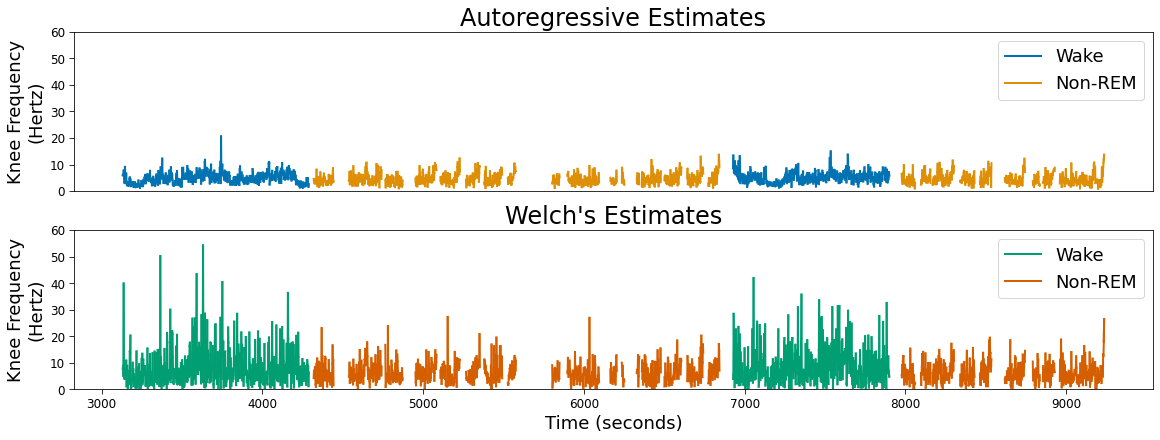

In [35]:
fig = plt.figure(constrained_layout=True, figsize=(16, 6))

gs = GridSpec(2, 1, figure=fig)

ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])

_plot_timeseries(ax0, times, knees_wake_ar, wake_starts, wake_mids, wake_ends, 'C0', 'Wake')   
_plot_timeseries(ax0, times, knees_nrem_ar, nrem_starts, nrem_mids, nrem_ends, 'C1', 'Non-REM')   

_plot_timeseries(ax1, times, knees_wake_welch, wake_starts, wake_mids, wake_ends, 'C2', 'Wake')   
_plot_timeseries(ax1, times, knees_nrem_welch, nrem_starts, nrem_mids, nrem_ends, 'C3', 'Non-REM')   

ax0.set_ylim(0, 60)
ax1.set_ylim(0, 60)
ax0.set_title('Autoregressive Estimates')
ax1.set_title('Welch\'s Estimates')
ax1.set_ylabel('Knee Frequency\n(Hertz)')
ax1.set_xlabel('Time (seconds)')
ax0.set_xticks([])
ax0.set_ylabel('Knee Frequency\n(Hertz)')
ax1.set_ylabel('Knee Frequency\n(Hertz)')

ax0.legend()
ax1.legend();

plt.savefig('fig6a_time_resolved.png', dpi=300, facecolor='w')

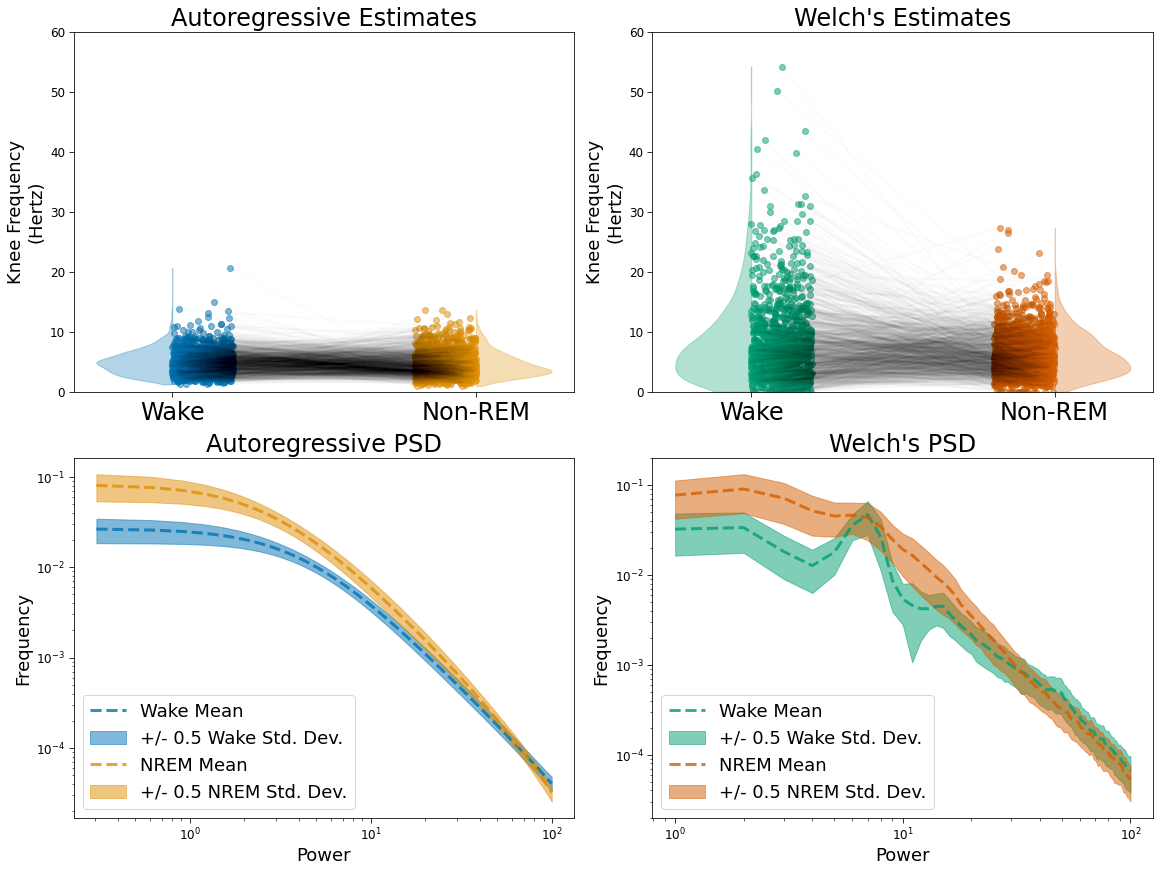

In [36]:
fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = GridSpec(2, 2, figure=fig)


ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])


plot_connected_scatter(knees_wake_ar, knees_nrem_ar, ax0, '',
                       alpha_line=.015, xticklabels=['Wake', 'Non-REM'])

plot_connected_scatter(knees_wake_welch, knees_nrem_welch, ax1, '',
                       alpha_line=.015, colors=['C2', 'C3'], xticklabels=['Wake', 'Non-REM'])

_plot_psd(ax2, freqs_wake_ar, powers_wake_ar, 'C0', .5, trial='Wake')
_plot_psd(ax2, freqs_nrem_ar, powers_nrem_ar, 'C1', .5, trial='NREM')

_plot_psd(ax3, freqs_wake_welch, powers_wake_welch, 'C2', .5, trial='Wake')
_plot_psd(ax3, freqs_nrem_welch, powers_nrem_welch, 'C3', .5, trial='NREM')

ax0.set_ylim(0, 60)
ax1.set_ylim(0, 60)

ax0.set_title('Autoregressive Estimates')
ax1.set_title('Welch\'s Estimates')
ax2.set_title('Autoregressive PSD')
ax3.set_title('Welch\'s PSD')

ax0.set_ylabel('Knee Frequency\n(Hertz)')
ax1.set_ylabel('Knee Frequency\n(Hertz)')

ax2.set_ylabel('Frequency')
ax3.set_ylabel('Frequency')

ax2.set_xlabel('Power')
ax3.set_xlabel('Power')

ax2.legend()
ax3.legend();

plt.savefig('fig6b_.png', dpi=300, facecolor='w')

In [37]:
print('Rat, Welch: ', ttest_ind(knees_wake_welch, knees_nrem_welch))
print('Rat, AR: ', ttest_ind(knees_wake_ar, knees_nrem_ar))

Rat, Welch:  Ttest_indResult(statistic=9.42326297144952, pvalue=9.942301442319902e-21)
Rat, AR:  Ttest_indResult(statistic=5.118076716826027, pvalue=3.3319535165258146e-07)


In [38]:
print('Rat, Wake: ', ttest_rel(knees_wake_welch, knees_wake_ar))
print('Rat, NREM: ', ttest_rel(knees_nrem_welch, knees_nrem_ar))

Rat, Wake:  Ttest_relResult(statistic=16.437154156126663, pvalue=2.767145125685312e-54)
Rat, NREM:  Ttest_relResult(statistic=17.915757097595577, pvalue=1.8323709052762835e-64)


In [39]:
print('Rat, Wake Welch: ', knees_wake_welch.mean(), knees_wake_welch.std())
print('Rat, NREM Welch: ', knees_nrem_welch.mean(), knees_nrem_welch.std())

print('Rat, Wake AR: ', knees_wake_ar.mean(), knees_wake_ar.std())
print('Rat, NREM AR: ', knees_nrem_ar.mean(), knees_nrem_ar.std())

Rat, Wake Welch:  8.29962826171875 6.966584964121487
Rat, NREM Welch:  6.192228497321797 3.7926572752263823
Rat, Wake AR:  4.997628462400279 2.0783291570695925
Rat, NREM AR:  4.5609902074506135 2.072236019423522
